In [1]:
# Loading in the basics
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from config import password

pd.options.display.float_format = "{:,.2f}".format


In [2]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [3]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = password,
                        host =     ENDPOINT,
                        port =     PORT)

In [4]:
# zillow final table sql
zillow_final_sql = '''
            SELECT *
            FROM zillow_final;
            '''

In [5]:
# setting up dfs
zillow_final_data_df = pd.read_sql(zillow_final_sql, conn)

In [6]:
# census table sql
census_sql = '''
            SELECT *
            FROM census;
            '''

In [7]:
# setting up dfs
census_data_df = pd.read_sql(census_sql, conn)

In [8]:
zillow_final_data_df["date"] = pd.to_datetime(zillow_final_data_df["date"])
zillow_final_data_df

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,"275,448.00","235,099.00",85.35,"40,349.00"
1,2017-11-11,0,United States,"275,448.00","234,750.00",85.22,"40,698.00"
2,2017-11-18,0,United States,"275,448.00","235,750.00",85.59,"39,698.00"
3,2017-11-25,0,United States,"274,975.00","235,916.00",85.80,"39,059.00"
4,2017-12-02,0,United States,"274,825.00","237,166.00",86.30,"37,659.00"
...,...,...,...,...,...,...,...
2207,2021-05-22,17,"San Diego, CA","849,925.00","745,500.00",87.71,"104,425.00"
2208,2021-05-22,13,"Riverside, CA","536,250.00","482,000.00",89.88,"54,250.00"
2209,2021-05-22,11,"San Francisco, CA","995,660.00","1,092,750.00",109.75,"-97,090.00"
2210,2021-05-22,2,"Los Angeles-Long Beach-Anaheim, CA","999,750.00","816,125.00",81.63,"183,625.00"


In [9]:
#full yearly dataframes
df_2017 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2017-01-01") & (zillow_final_data_df["date"] <= "2017-12-31")]
df_2018 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2018-01-01") & (zillow_final_data_df["date"] <= "2018-12-31")]
df_2019 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2019-01-01") & (zillow_final_data_df["date"] <= "2019-12-31")]
df_2020 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2020-01-01") & (zillow_final_data_df["date"] <= "2020-12-31")]
df_2021 = zillow_final_data_df.loc[(zillow_final_data_df["date"] >= "2021-01-01") & (zillow_final_data_df["date"] <= "2021-12-31")]

df_2017

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017-11-04,0,United States,"275,448.00","235,099.00",85.35,"40,349.00"
1,2017-11-11,0,United States,"275,448.00","234,750.00",85.22,"40,698.00"
2,2017-11-18,0,United States,"275,448.00","235,750.00",85.59,"39,698.00"
3,2017-11-25,0,United States,"274,975.00","235,916.00",85.80,"39,059.00"
4,2017-12-02,0,United States,"274,825.00","237,166.00",86.30,"37,659.00"
...,...,...,...,...,...,...,...
457,2017-12-30,13,"Riverside, CA","391,275.00","356,438.00",91.10,"34,837.00"
458,2017-12-30,11,"San Francisco, CA","811,943.00","749,188.00",92.27,"62,755.00"
459,2017-12-30,2,"Los Angeles-Long Beach-Anaheim, CA","818,914.00","618,750.00",75.56,"200,164.00"
460,2017-12-30,25,"Sacramento, CA","469,870.00","393,375.00",83.72,"76,495.00"


In [10]:
# creating single point year by year averages to merge with census data
df_annual = pd.DataFrame(columns = ["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"])
df_annual.loc["2017"] = df_2017.mean()
df_annual.loc["2018"] = df_2018.mean()
df_annual.loc["2019"] = df_2019.mean()
df_annual.loc["2020"] = df_2020.mean()
df_annual.loc["2021"] = df_2021.mean()

df_annual.to_csv("resources/total_annual_mean.csv", index=False)

In [11]:
# dividing df into regions

df_united_states = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "United States"]
df_california = zillow_final_data_df.loc[zillow_final_data_df["region_name"] == "California"].dropna()
df_california_cities =zillow_final_data_df.loc[(zillow_final_data_df["region_name"] != "United States") & (zillow_final_data_df["region_name"] != "California")]

df_california.shape

(186, 7)

In [12]:
#full yearly dataframes for cities in california
# i am sure there is a method to use fewer lines to do all this and reduce dates to just the year, but the following steps are my work around
df_ca_city_2017 = df_california_cities.loc[(df_california_cities["date"] >= "2017-01-01") & (df_california_cities["date"] <= "2017-12-31")]
df_ca_city_2018 = df_california_cities.loc[(df_california_cities["date"] >= "2018-01-01") & (df_california_cities["date"] <= "2018-12-31")]
df_ca_city_2019 = df_california_cities.loc[(df_california_cities["date"] >= "2019-01-01") & (df_california_cities["date"] <= "2019-12-31")]
df_ca_city_2020 = df_california_cities.loc[(df_california_cities["date"] >= "2020-01-01") & (df_california_cities["date"] <= "2020-12-31")]
df_ca_city_2021 = df_california_cities.loc[(df_california_cities["date"] >= "2021-01-01") & (df_california_cities["date"] <= "2021-12-31")]
df_ca_city_2017

,date,size_rank,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
372,2017-11-04,17,"San Diego, CA","728,005.00","541,438.00",74.37,"186,567.00"
373,2017-11-04,11,"San Francisco, CA","867,930.00","781,063.00",89.99,"86,867.00"
374,2017-11-04,13,"Riverside, CA","388,757.00","342,999.00",88.23,"45,758.00"
375,2017-11-04,2,"Los Angeles-Long Beach-Anaheim, CA","812,252.00","611,250.00",75.25,"201,002.00"
376,2017-11-04,77,"Stockton, CA","408,007.00","357,875.00",87.71,"50,132.00"
...,...,...,...,...,...,...,...
457,2017-12-30,13,"Riverside, CA","391,275.00","356,438.00",91.10,"34,837.00"
458,2017-12-30,11,"San Francisco, CA","811,943.00","749,188.00",92.27,"62,755.00"
459,2017-12-30,2,"Los Angeles-Long Beach-Anaheim, CA","818,914.00","618,750.00",75.56,"200,164.00"
460,2017-12-30,25,"Sacramento, CA","469,870.00","393,375.00",83.72,"76,495.00"


In [13]:
#prepping for use alongside census data

df_ca_city_2017 = df_ca_city_2017.groupby("region_name", as_index = False)["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"].mean()
df_ca_city_2017.insert(0, "year", 2017)
df_ca_city_2018 = df_ca_city_2018.groupby("region_name", as_index = False)["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"].mean()
df_ca_city_2018.insert(0, "year", 2018)
df_ca_city_2019 = df_ca_city_2019.groupby("region_name", as_index = False)["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"].mean()
df_ca_city_2019.insert(0, "year", 2019)
df_ca_city_2020 = df_ca_city_2020.groupby("region_name", as_index = False)["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"].mean()
df_ca_city_2020.insert(0, "year", 2020)
df_ca_city_2021 = df_ca_city_2021.groupby("region_name", as_index = False)["list_price", "sale_price", "list_divided_by_sale", "list_minus_sale"].mean()
df_ca_city_2021.insert(0, "year", 2021)


D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':
D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (impli

In [41]:
df_annual_city = pd.concat([df_ca_city_2017, df_ca_city_2018, df_ca_city_2019, df_ca_city_2020, df_ca_city_2021], ignore_index = True)
df_annual_city.to_csv("resources/ca_city_annual.csv", index = False)
df_annual_city

,year,region_name,list_price,sale_price,list_divided_by_sale,list_minus_sale
0,2017,"Bakersfield, CA","261,989.56","230,264.11",87.90,"31,725.44"
1,2017,"Fresno, CA","340,529.22","268,083.33",78.73,"72,445.89"
2,2017,"Los Angeles-Long Beach-Anaheim, CA","816,180.89","616,639.11",75.55,"199,541.78"
3,2017,"Riverside, CA","389,225.11","350,541.67",90.06,"38,683.44"
4,2017,"Sacramento, CA","467,075.00","391,028.00",83.72,"76,047.00"
5,2017,"San Diego, CA","727,886.44","553,173.89",76.00,"174,712.56"
6,2017,"San Francisco, CA","837,240.67","778,667.00",93.02,"58,573.67"
7,2017,"San Jose, CA","1,093,434.67","992,319.67",90.77,"101,115.00"
8,2017,"Stockton, CA","407,033.89","368,779.22",90.60,"38,254.67"
9,2017,"Ventura, CA","771,527.44","592,111.44",76.75,"179,416.00"


In [15]:
# loading libraries for prophet.

from fbprophet import Prophet
import numpy as np
from pandas import DataFrame, to_datetime
from sklearn.metrics import mean_absolute_error


Importing plotly failed. Interactive plots will not work.


In [16]:
df = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df["ds"] = df_california_cities.loc[:, "date"]  # changing the dataframe here and the line below will change output
df["y"] = df_california_cities.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [17]:
future = model.make_future_dataframe(periods = 365) #predicting next year in sale_price of california cities 
for i in range(1, 13):
	date = '2021-%02d' % i 
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

             ds       yhat  yhat_lower   yhat_upper
2200 2022-05-18 684,799.27  399,414.23 1,007,404.98
2201 2022-05-19 684,578.56  375,013.44   996,597.41
2202 2022-05-20 684,301.62  376,571.54 1,023,330.84
2203 2022-05-21 683,973.86  366,340.91   973,940.59
2204 2022-05-22 683,601.87  348,652.31   994,283.62


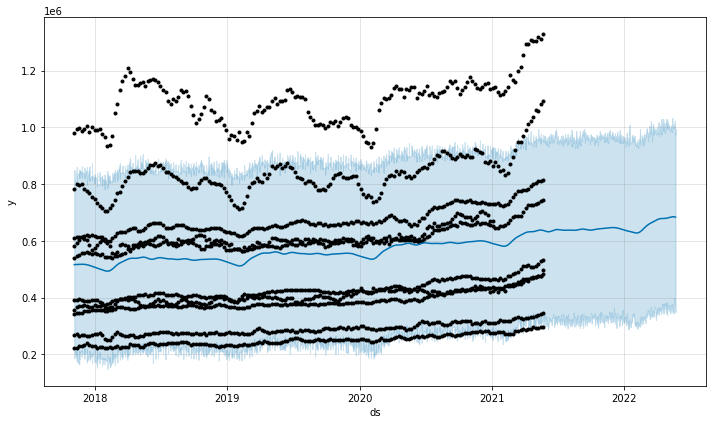

In [18]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

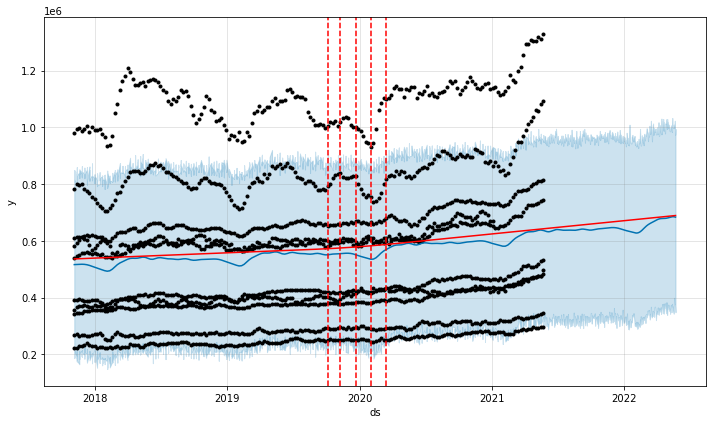

In [19]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast) #default changepoints model

In [21]:
forecast.to_csv("resources/city_forecast.csv")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


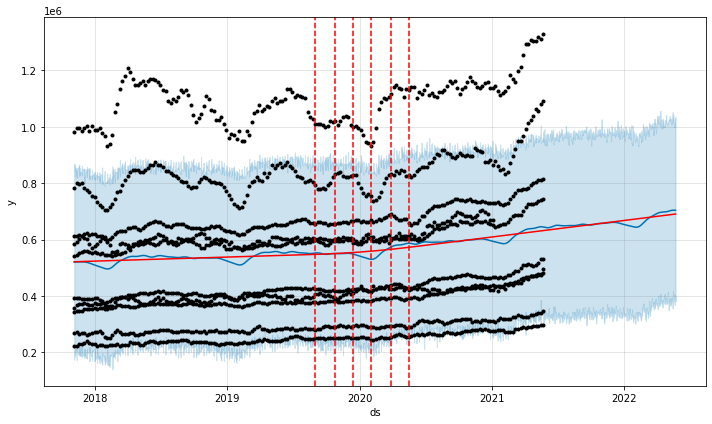

In [22]:
# messing with change_point scaling to double check the tight grouping in previous graph
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Flatten,LSTM,RepeatVector,TimeDistributed,Conv1D,MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from livelossplot.tf_keras import PlotLossesCallback
from statsmodels.tsa.seasonal import seasonal_decompose

In [24]:
df_1 = pd.DataFrame(columns = ["x", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp

df_1["x"] = df_california.loc[:,"list_price"]
df_1["y"] = df_california.loc[:,"sale_price"]
df_1.head()

,x,y
186,"614,123.70","508,281.30"
187,"613,946.70","514,450.00"
188,"614,898.40","516,943.90"
189,"612,118.70","517,912.70"
190,"608,753.30","517,612.80"


In [25]:
def train_test_builder(df,size_test=24,length_train_sequence = 24,length_forecast = 12, normalize = False):
    
    train_df_1 = df_1[:-size_test]    
    
    # create training sets
    train_x,train_y = window_splitter(train_df_1)
    
    # create test set
    tmp = df_1[:length_forecast]
    tmp = pd.concat([df_1,tmp],ignore_index = True)
    tmp[-length_forecast:] = np.nan  # unknown
    test_x,test_y = window_splitter(tmp)
    # drop elements in training
    test_x = test_x[train_x.shape[0]:]
    test_y = test_y[train_x.shape[0]:]
    for i in range(length_forecast):
        test_y[i,:(11-i)]=np.nan # present in training_set
    
    # normalize
    if normalize:
        m = train_df_1.x.mean()
        sd = train_df_1.x.std()
        train_x -= m
        train_x/= sd
        test_x -=m
        test_x /= sd
    
    return train_x,train_y,test_x,test_y


# iterate over the time steps and divide the data into overlapping windows; 
def window_splitter(train_df_1,length_train_sequence = 24,length_forecast = 12):
    i = 0
    x,y = [],[]
    while i + length_train_sequence+ length_forecast < len(train_df_1):
        x.append(train_df_1.x[i:(i+length_train_sequence)].values)
        y.append(train_df_1.x[(i+length_train_sequence):(i+length_train_sequence+length_forecast)].values)
        i+=1

    x = np.array(x).reshape(-1,length_train_sequence,1)
    y = np.array(y).reshape(-1,length_forecast)
    
    return x,y

D:\anaconda\envs\ml_\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


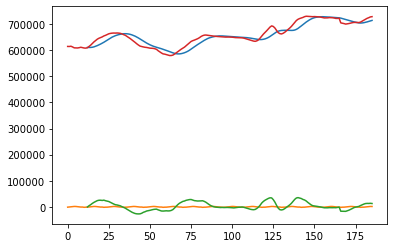

In [26]:
# a naive seasonal decomposition
series = df_1.x.values
result = seasonal_decompose(series, model='additive',freq=12,two_sided = False,)
plt.plot(result.trend)
plt.plot(result.seasonal)
plt.plot(result.resid)
plt.plot(result.observed)

In [27]:
train_x,train_y,test_x,test_y = train_test_builder(df_1)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((126, 24, 1), (126, 12), (36, 24, 1), (36, 12))

In [28]:

# evaluation function
def evaluate_predictions(pred_y, test_y):
    return pd.DataFrame(abs(test_y-pred_y)).mean(skipna = True)


def plot_evaluation(pred_y,test_y,n=12):
    scores = evaluate_predictions(pred_y,test_y)

    print("Mean absolute error test set:",scores.mean())

    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1,13),scores)
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.ylabel("MAE", size = 15)
    plt.title("Scores LSTM on test set")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.title("LSTM forecasting - test set window")
    plt.plot(np.arange(1,13),pred_y[n:(n+1)].reshape(-1,1),label = "predictions")
    plt.plot(np.arange(1,13),test_y[n:(n+1)].reshape(-1,1),label = "true values")
    plt.xticks(np.arange(1,13))
    plt.xlabel("horizon [months]", size = 15)
    plt.legend()
    plt.show()

In [29]:

n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(None, 1)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.1))
model.add(Dense(n_outputs))

# compile
model.compile(loss='mse', optimizer= Adam(lr=1e-3), metrics = ["mae"])

# callbacks
early_stopping = EarlyStopping(patience=32, monitor='val_loss', mode='auto', restore_best_weights=True)
callbacks=[PlotLossesCallback(), early_stopping]

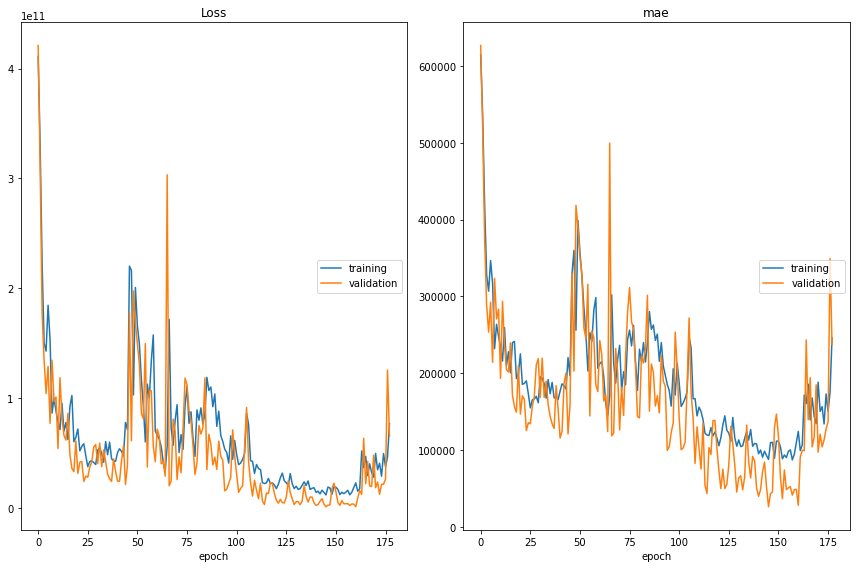

Loss
	training         	 (min: 11875754030.545, max: 411160716008.727, cur: 76775774114.909)
	validation       	 (min: 1097149568.000, max: 421106810880.000, cur: 65631129600.000)
mae
	training         	 (min: 87216.781, max: 614039.250, cur: 245965.734)
	validation       	 (min: 26206.605, max: 626658.500, cur: 237268.625)
88/88 [==============================] - 1s 8ms/sample - loss: 76775774114.9091 - mae: 245965.7344 - val_loss: 65631129600.0000 - val_mae: 237268.6250


In [30]:
model.fit(train_x, train_y, 
          validation_split = 0.3, 
          epochs=500, 
          shuffle = True,
          batch_size=50,
          verbose=1,
          callbacks = callbacks,
         )

Mean absolute error test set: 50649.73678240741


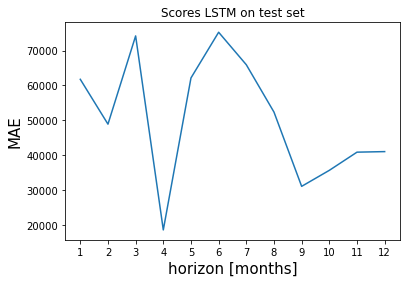

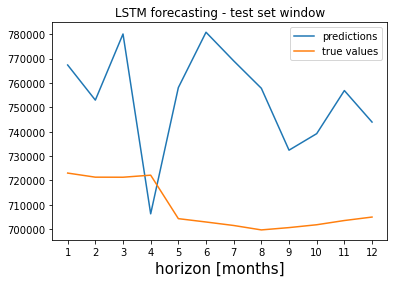

In [31]:
pred_y = model.predict(test_x)
# add seasonality of the past year
for i in np.arange(pred_y.shape[0]-1,-1,-1):
    pred_y[pred_y.shape[0]-1-i] += result.seasonal[-(13+i):-(1+i)]

plot_evaluation(pred_y,test_y,n=12)


In [32]:
tmp = pd.DataFrame(test_y-pred_y)
tmp.columns = np.arange(1,13)

tmp.to_csv("resources/california_state_lstm.csv",index = False)

In [33]:
df_2 = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df_2["ds"] = df_california.loc[:, "date"]  # changing the dataframe here and the line below will change output
df_2["y"] = df_california.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df_2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


             ds       yhat  yhat_lower  yhat_upper
2200 2022-05-18 791,995.99  705,774.97  888,486.01
2201 2022-05-19 792,517.31  704,975.92  888,730.89
2202 2022-05-20 793,032.72  705,424.13  889,391.89
2203 2022-05-21 793,543.32  705,740.65  891,811.95
2204 2022-05-22 794,050.52  704,490.43  893,468.12


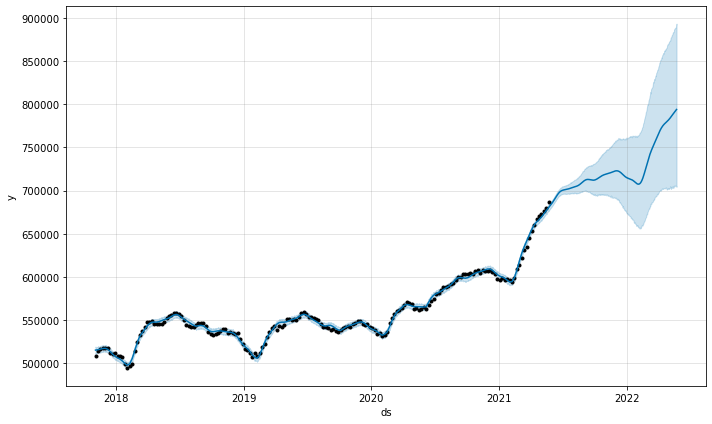

In [34]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


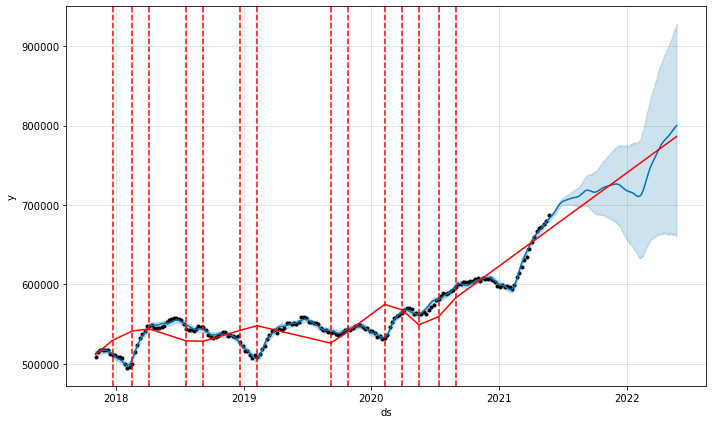

In [35]:
# messing with change_point scaling to double check the tight grouping in previous graph
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df_2).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [36]:
forecast.to_csv("resources/california_forecast.csv")

In [37]:
df_3 = pd.DataFrame(columns = ["ds", "y"]) # ds, and y are the "expected" options for columns in prophet, ds= datestamp
df_3["ds"] = df_united_states.loc[:, "date"]  # changing the dataframe here and the line below will change output
df_3["y"] = df_united_states.loc[:, "sale_price"] # change column name for more models
model = Prophet(daily_seasonality = True, yearly_seasonality = True)
# fit the model
model.fit(df_3)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


             ds       yhat  yhat_lower  yhat_upper
2200 2022-05-18 374,860.34  299,412.31  441,438.10
2201 2022-05-19 375,223.45  299,201.75  442,047.12
2202 2022-05-20 375,597.47  298,834.11  441,855.47
2203 2022-05-21 375,981.41  299,298.11  442,906.88
2204 2022-05-22 376,374.23  298,862.30  444,564.81


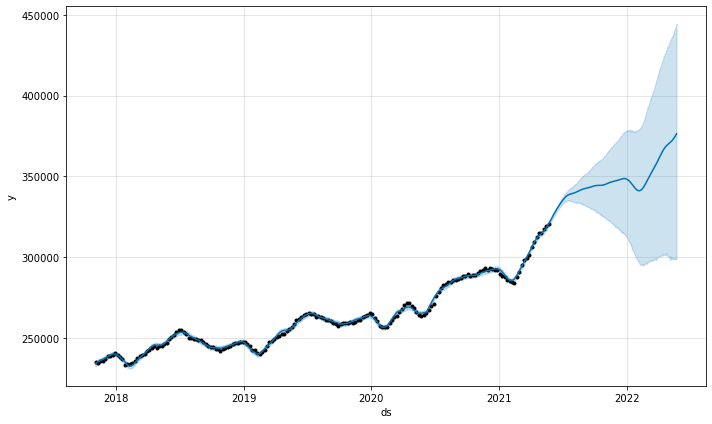

In [38]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
model.plot(forecast)
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


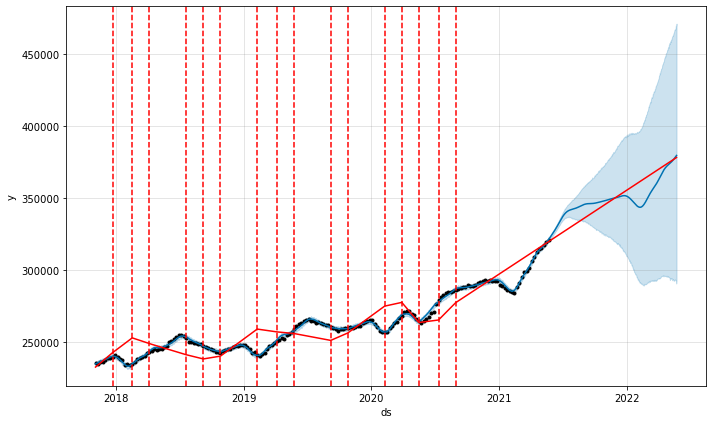

In [39]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08) 
forecast = pro_change.fit(df_3).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [40]:
forecast.to_csv("resources/united_states_forecast.csv")